
#Demo de uso de TF-Hub  para detectar múltiples objetos en una imagen
Basado en info de 

https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb

y 

https://www.tensorflow.org/hub/tutorials/tf2_object_detection?hl=es-419

In [ ]:
#@title Clonar el repositorio de modelos de TF si no está ya disponible

#Clonar el repositorio de modelos de TF si no está ya disponible
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
#@title Instalar el Object Detection API
# Nota: si falla por falta de requerimientos, ejecutarlo de nuevo y funcionará ;)...
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696777 sha256=44587bb168cfc0256336b9581c00d007be3312ee3e2634f407d255512e1d3566
  Stored in directory: /tmp/pip-ephem-wheel-cache-vikag5_u/wheels/7d/96/c1/072a751379735e8dfdada1def1c62a89afb3cc45654fd6fd28
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [ ]:
#@title Cargar Librerías
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time
import os

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

print("Librerías cargadas.")

Librerías cargadas.


In [ ]:
#@title Seleccionar el modelo de TF-Hub a utilizar

seleccionar_modelo = 'CenterNet Resnet50 V2 Keypoints 512x512' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']

# configuración de modelos
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

model_handle = ALL_MODELS[seleccionar_modelo]

# carga el módulo a usar
detector = hub.load(model_handle)

print("\n\nModelo ", seleccionar_modelo, "cargado desde", model_handle)



def procesarImagenNP(seleccionar_modelo, converted_img, min_score_display, max_boxes_per_image, mostrar_tiempo_ejecucion=False, mostrar_subimagenes_objetos=False):

      # procesa la imagen en el modelo previamente cargado
      # devolviendo un vector con los resultados   
      start_time = time.time()
      result = detector(converted_img)
      end_time = time.time()  

      # controla parámetros
      if min_score_display > 1:
        min_score_display = 0.9
      if min_score_display < 0:
        min_score_display = 0
      if max_boxes_per_image < 0:
        max_boxes_per_image = 10      


      # prepara para visualizar los boxes
      result = {key:value.numpy() for key,value in result.items()}
      label_id_offset = 0
      image_with_boxes = converted_img.copy()
      
      if "mask" in seleccionar_modelo.lower():
          # es object segmentation
          if 'detection_masks' in result:
            # we need to convert np.arrays to tensors
            detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
            detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

            # Reframe the bbox mask to the image size.
            detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                      detection_masks, detection_boxes,
                        image_with_boxes.shape[1], image_with_boxes.shape[2])
            detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                                tf.uint8)
            result['detection_masks_reframed'] = detection_masks_reframed.numpy()

          viz_utils.visualize_boxes_and_labels_on_image_array(
                image_with_boxes[0],
                result['detection_boxes'][0],
                (result['detection_classes'][0] + label_id_offset).astype(int),
                result['detection_scores'][0],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=max_boxes_per_image,
                min_score_thresh=min_score_display,
                agnostic_mode=False,
                instance_masks=result.get('detection_masks_reframed', None),
                line_thickness=8)
      else:  
          # es object detection común          
          # Use keypoints if available in detections
          keypoints, keypoint_scores = None, None
          if 'detection_keypoints' in result:
            keypoints = result['detection_keypoints'][0]
            keypoint_scores = result['detection_keypoint_scores'][0]

          viz_utils.visualize_boxes_and_labels_on_image_array(
                image_with_boxes[0],
                result['detection_boxes'][0],
                (result['detection_classes'][0] + label_id_offset).astype(int),
                result['detection_scores'][0],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=max_boxes_per_image,
                min_score_thresh=min_score_display,
                agnostic_mode=False,
                keypoints=keypoints,
                keypoint_scores=keypoint_scores,
                keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

      # muestra la imagen con los objetos detectados
      #image_with_boxes.reshape( converted_img.shape )
      imMostrar = Image.fromarray(image_with_boxes[0], 'RGB')
      display( imMostrar )

      countBoxDisplayed = 0
      countObjMinScore = 0
      for eachScore in result["detection_scores"][0]:
        countBoxDisplayed = countBoxDisplayed + 1
        if eachScore >= min_score_display:
          countObjMinScore = countObjMinScore + 1

      print(" -- Objetos mostrados: %d de %d detectados total" % (countObjMinScore, len(result["detection_boxes"][0])) )
      print(" -- Objetos detectados con mínimo score %3.2f: %d" % (min_score_display*100, countObjMinScore) )
      if mostrar_tiempo_ejecucion:
        print(" -- Tiempo de procesamiento: %3.2f segundos " % (end_time - start_time))

      if mostrar_subimagenes_objetos:
        print("\n ** Sub-Imágenes:")
        imCargada_ancho, imCargada_alto = imMostrar.size

        # muestra detalle de los objetos detectados
        for detClass, detBox, detScore in zip( result["detection_classes"][0], result["detection_boxes"][0],  result["detection_scores"][0]):    
          if detScore >= min_score_display:
              print("\n\t* clase ", category_index[detClass]["name"], "con", round(detScore*100, 2), "% en box ", detBox)

            # como las coordenadas están normalizadas las debe convertir 
              # teniendo en cuenta el tamaño de la imagen
              # además notar que vienen datas en otro orden
              # - detBox = (ini alto, ini ancho, fin alto, fin ancho)
              # - nuevoRangoIn = (ini ancho, ini alto, fin ancho, fin alto)    
              nuevoRangoIm = (detBox[1] * imCargada_ancho, 
                              detBox[0] * imCargada_alto,
                              detBox[3] * imCargada_ancho,
                              detBox[2] * imCargada_alto) 
              display ( imMostrar.crop(nuevoRangoIm) )

print("Función procesarImagenNP definida.")



Modelo  CenterNet Resnet50 V2 Keypoints 512x512 cargado desde https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1
Función procesarImagenNP definida.


In [ ]:
#@title Cargar definición de las Clases 
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]


print(len(category_index), "clases definidas.")

80 clases definidas.


In [ ]:
#@title Acceder al Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/MUCHOS'  #@param {type:"string"}

Mounted at /content/gdrive


In [ ]:
#@title Cargar imágenes del directorio del Drive

# levanta imágenes 
all_imagesName_array = []
all_imagesInfo_array = []
auxiPath = path
all_files = os.listdir(auxiPath)
for each_file in all_files:
    if(each_file.endswith(".jpg") or each_file.endswith(".png")):
        # determina nombre imagen
        imName = auxiPath + "/" + each_file                
        # carga la imagen 
        imag = Image.open(imName)
        (im_width, im_height) = imag.size
        #print(  (im_width, im_height) )
        
        # convierte a vector
        converted_img = np.array(imag.getdata()).reshape(
            (1, im_height, im_width, 3)).astype(np.uint8)
        #print( converted_img.shape )

        all_imagesName_array.append( imName )
        all_imagesInfo_array.append( converted_img ) 

print(len(all_imagesName_array), " imágenes cargadas.")

6  imágenes cargadas.


> Modelo  CenterNet Resnet50 V2 Keypoints 512x512 :


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/plazaMayo.jpg


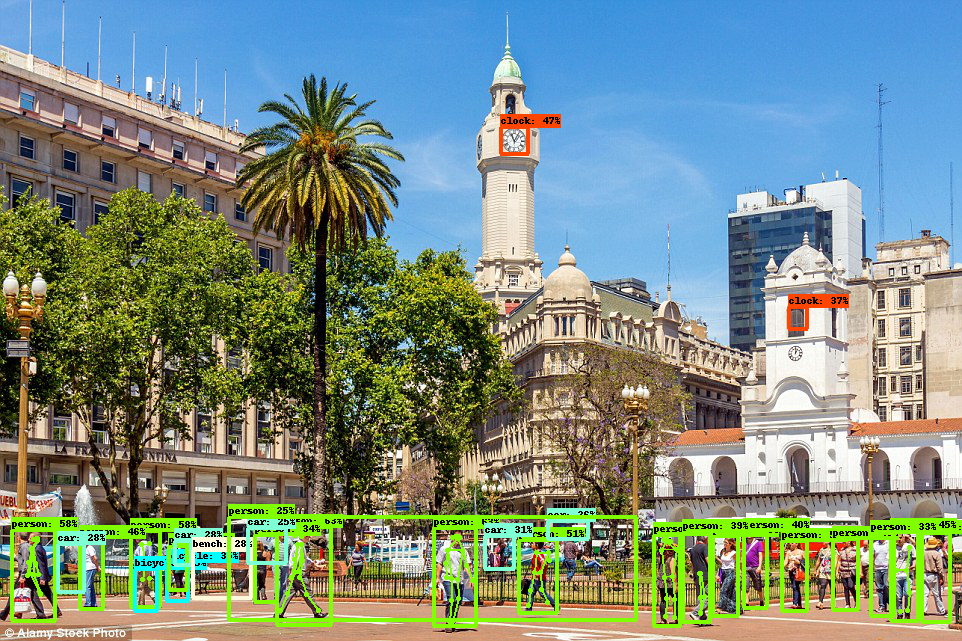

 -- Objetos mostrados: 28 de 100 detectados total
 -- Objetos detectados con mínimo score 25.00: 28
 -- Tiempo de procesamiento: 1.42 segundos 

-----------------------------------------------------------------------------


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/asado.jpg


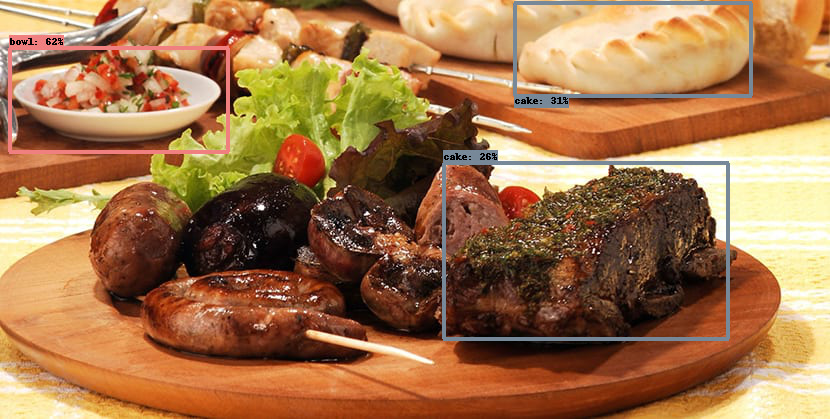

 -- Objetos mostrados: 3 de 100 detectados total
 -- Objetos detectados con mínimo score 25.00: 3
 -- Tiempo de procesamiento: 1.59 segundos 

-----------------------------------------------------------------------------


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/obelisco.jpg


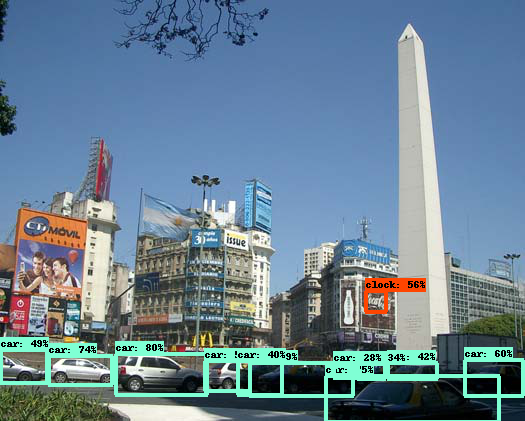

 -- Objetos mostrados: 12 de 100 detectados total
 -- Objetos detectados con mínimo score 25.00: 12
 -- Tiempo de procesamiento: 1.47 segundos 

-----------------------------------------------------------------------------


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/laBoca.jpg


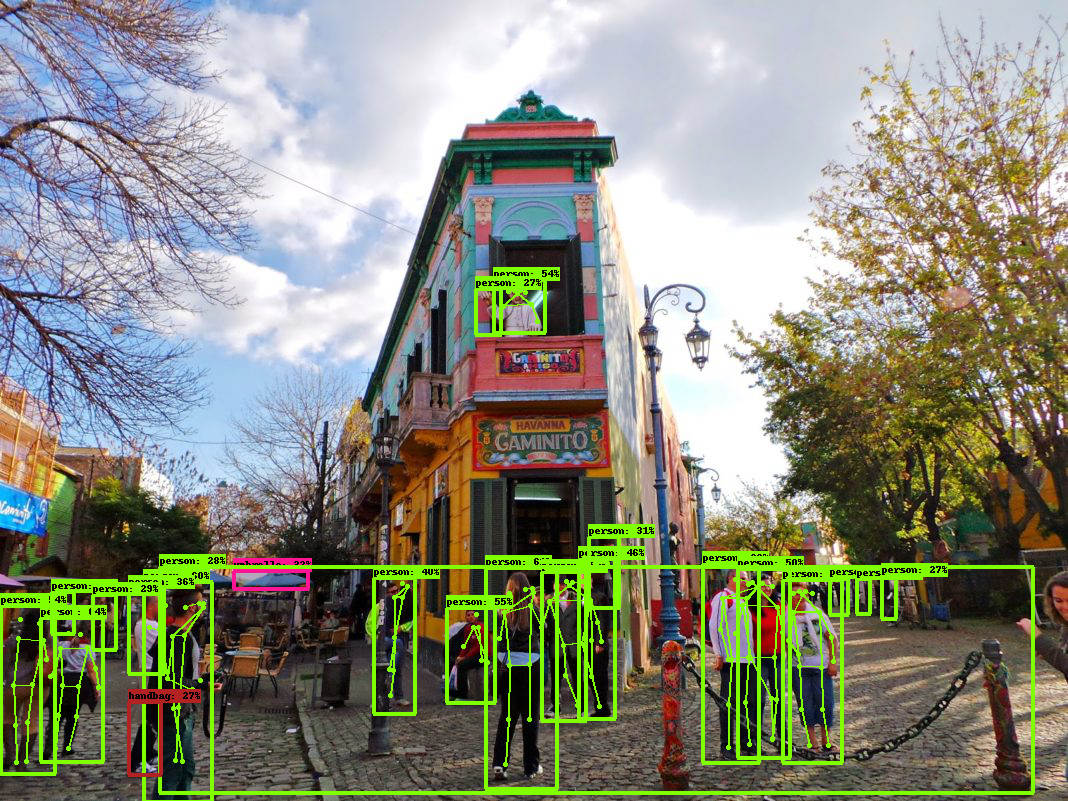

 -- Objetos mostrados: 23 de 100 detectados total
 -- Objetos detectados con mínimo score 25.00: 23
 -- Tiempo de procesamiento: 2.10 segundos 

-----------------------------------------------------------------------------


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/animales.jpg


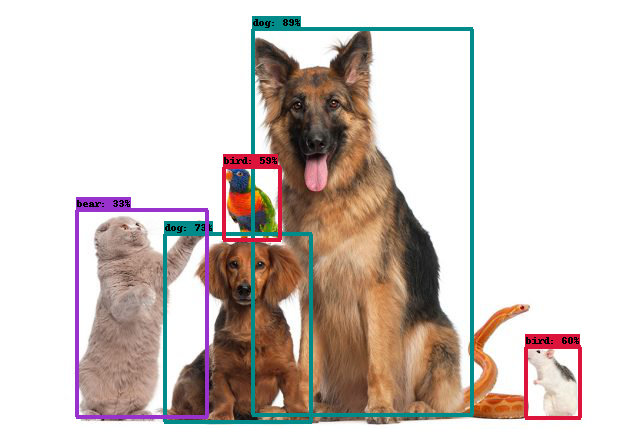

 -- Objetos mostrados: 5 de 100 detectados total
 -- Objetos detectados con mínimo score 25.00: 5
 -- Tiempo de procesamiento: 2.51 segundos 

-----------------------------------------------------------------------------


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/festival.jpg


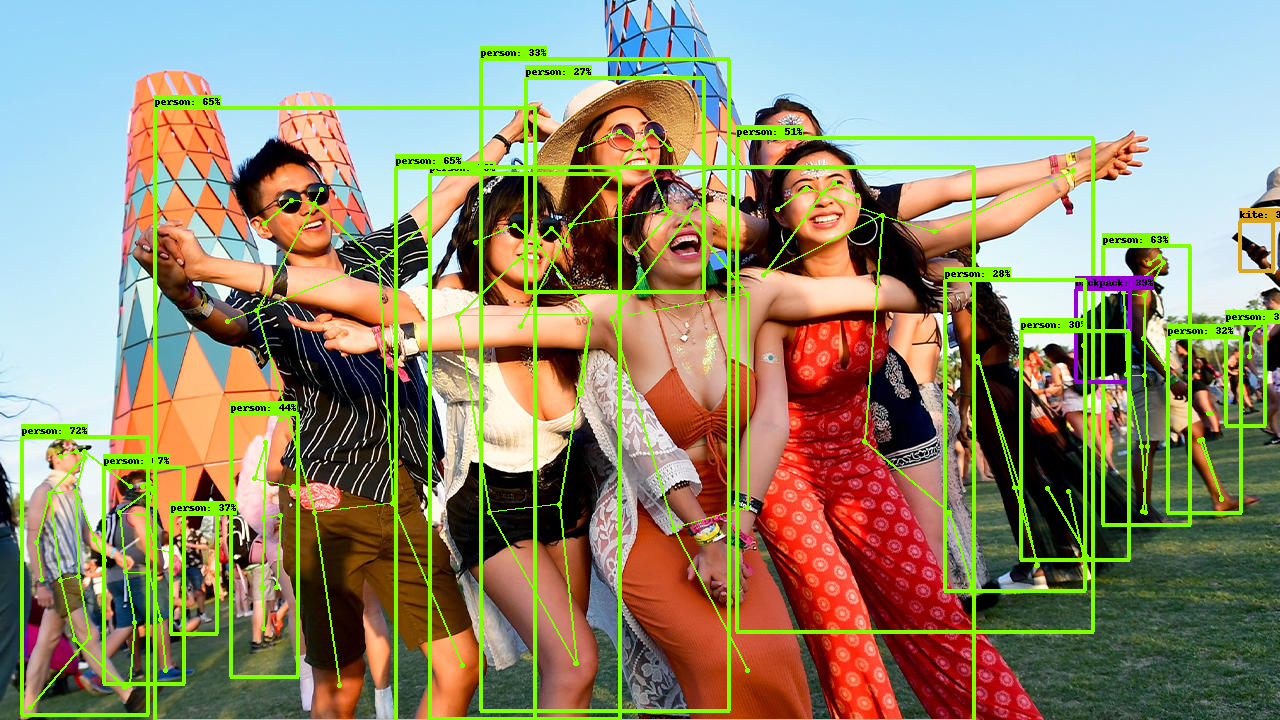

 -- Objetos mostrados: 17 de 100 detectados total
 -- Objetos detectados con mínimo score 25.00: 17
 -- Tiempo de procesamiento: 2.45 segundos 

-----------------------------------------------------------------------------



In [ ]:
#@title Procesar imágenes por el modelo seleccionado

# define la minima probabilidad que se va a usar para detectar objetos
drive_minimaProbabilidad = 25 #@param {type:"slider", min:0, max:100, step:1}
drive_max_boxes_per_image = 100 #@param {type:"integer"}

drive_mostrar_tiempo_ejecucion = True 
drive_mostrar_subimagenes_objetos = False #@param {type:"boolean"}

# indica si muestra detalle de resultados o no
print("> Modelo ", seleccionar_modelo, ":\n")

# procesalas imágenes cargadas
for name_img, converted_img in zip(all_imagesName_array, all_imagesInfo_array):
  print("\n* ", name_img)
  procesarImagenNP(seleccionar_modelo, 
                   converted_img, 
                   drive_minimaProbabilidad/100, 
                   drive_max_boxes_per_image, 
                   drive_mostrar_tiempo_ejecucion, 
                   drive_mostrar_subimagenes_objetos)
  print("\n-----------------------------------------------------------------------------\n")

> Modelo  CenterNet Resnet50 V2 Keypoints 512x512 :



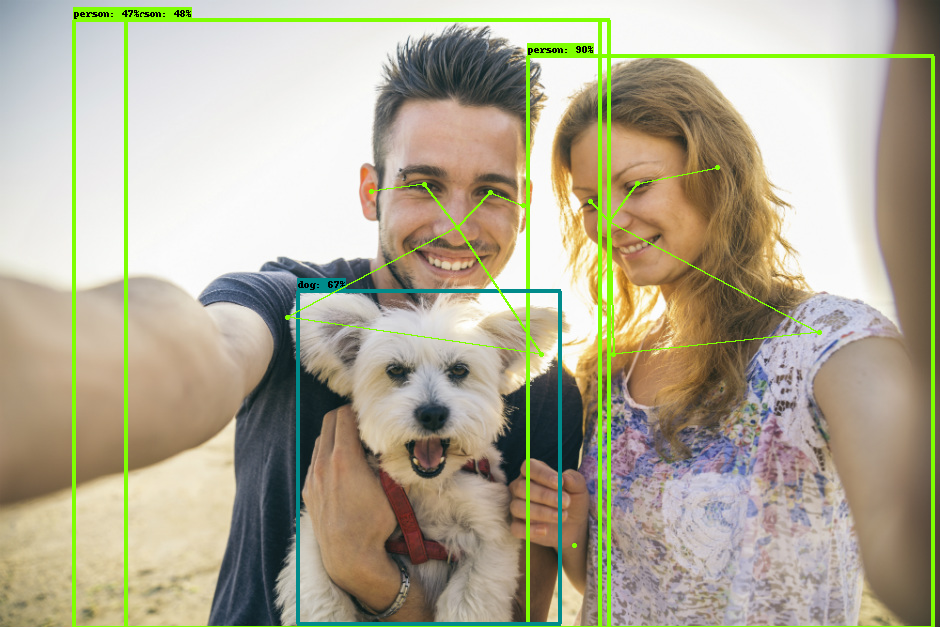

 -- Objetos mostrados: 4 de 100 detectados total
 -- Objetos detectados con mínimo score 45.00: 4
 -- Tiempo de procesamiento: 1.42 segundos 

 ** Sub-Imágenes:

	* clase  person con 90.05 % en box  [0.0903273  0.56099284 1.         0.99272287]


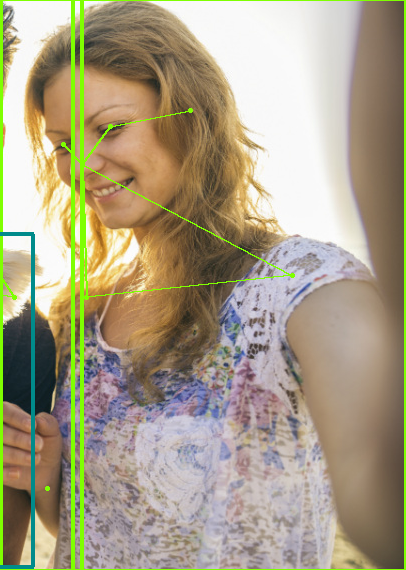


	* clase  dog con 67.18 % en box  [0.46489373 0.31650233 0.9946086  0.5967532 ]


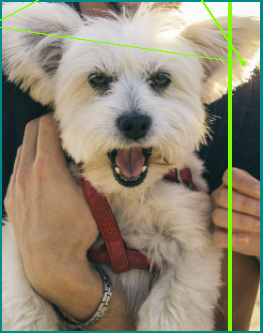


	* clase  person con 47.58 % en box  [0.03308449 0.1336602  1.         0.63928986]


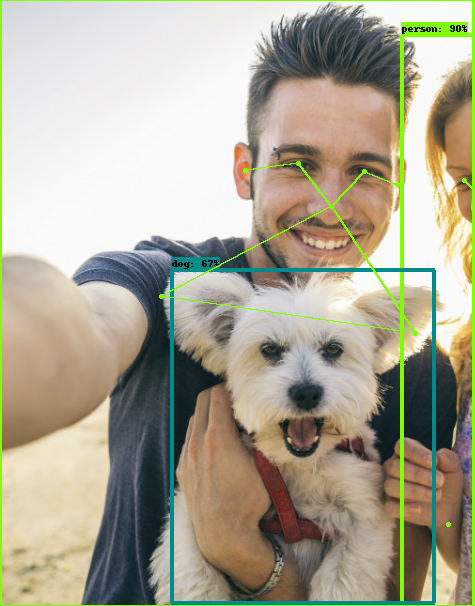


	* clase  person con 47.31 % en box  [0.03343018 0.07801363 1.         0.6486577 ]


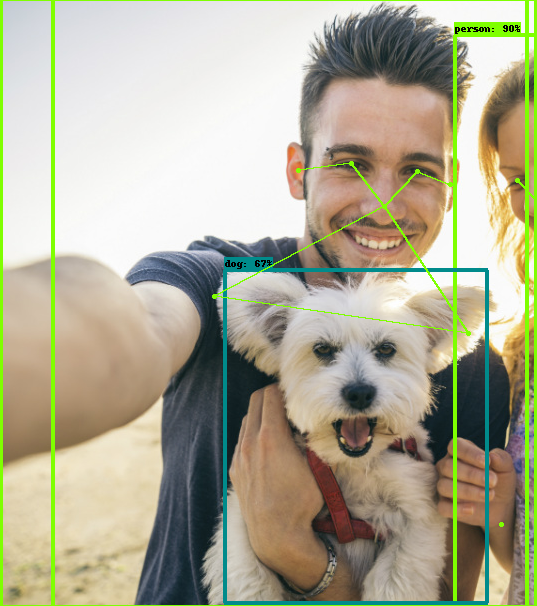

In [ ]:
#@title Procesar imagen desde URL

import requests # request img from web
import shutil # save img locally

imagen_URL = "https://static.fundacion-affinity.org/cdn/farfuture/54n76QrL7YrsyLSTQlAzpJnwCz54nW1MsmYw2QJcIII/mtime:1528830295/sites/default/files/antrozoologia-conociendo-el-vinculo-entre-personas-y-otros-animales.jpg" #@param {type:"string"}

URL_minimaProbabilidad = 45 #@param {type:"slider", min:0, max:100, step:1}
URL_max_boxes_per_image = 100 #@param {type:"integer"}

URL_mostrar_tiempo_ejecucion = True 
URL_mostrar_subimagenes_objetos = True

if imagen_URL != "":

    # baja la imagen
    URL_file_name = "./donwload_image.jpg"
    res = requests.get(imagen_URL, stream = True)
    if res.status_code == 200:
        with open(URL_file_name,'wb') as f:
            shutil.copyfileobj(res.raw, f)
    else:
        print('No se puede desacargar la imagen')
        
    # abre la imagen
    URL_imag = Image.open(URL_file_name)
    (URL_im_width, URL_im_height) = URL_imag.size

    # convierte a vector
    URL_converted_img = np.array(URL_imag.getdata()).reshape(
        (1, URL_im_height, URL_im_width, 3)).astype(np.uint8)

    # indica si muestra detalle de resultados o no
    print("> Modelo ", seleccionar_modelo, ":\n")

    procesarImagenNP(seleccionar_modelo, 
                    URL_converted_img, 
                    URL_minimaProbabilidad/100, 
                    URL_max_boxes_per_image, 
                    URL_mostrar_tiempo_ejecucion, 
                    URL_mostrar_subimagenes_objetos)